<a href="https://colab.research.google.com/github/yyyyyYvvvvV/Worldmodel2023_10/blob/Hirai/2023_world_model_%E7%AC%AC08%E5%9B%9E%E6%BC%94%E7%BF%92_%E4%B8%96%E7%95%8C%E3%83%A2%E3%83%86%E3%82%99%E3%83%AB%E3%81%A8%E3%82%B7%E3%83%BC%E3%83%B3%E7%90%86%E8%A7%A3_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2023年 世界モデル第8回演習

本演習では，[Weisらの実装](https://github.com/ecker-lab/object-centric-representation-benchmark)を元に，動画データから物体の表現を推論する物体中心表現学習モデルの一つ，**ViMON** [[1]](https://jmlr.org/papers/volume22/21-0199/21-0199.pdf)を実装します．ViMONはMONet [[2]](https://arxiv.org/abs/1901.11390)を動画に拡張したモデルです．

1. [準備](#scrollTo=k5L4x7ROQ6Rj)
2. [データセットの準備](#scrollTo=kWVQ46yTg9Qv)
3. [モデルの実装](#scrollTo=zfY4NKSdOWl1)
4. [学習](#scrollTo=9WSD0A6GvZrB)
5. [結果の確認](#scrollTo=95uVhojfMXZW)
6. [参考文献](#scrollTo=Kib8iOMKGwub)

## 1.準備

In [ ]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


配布した`lecture08_utils.zip`をご自身のGoogle Driveにコピー，解凍してください．ここで，zipファイルを置いたディレクトリのパスを指定します．

In [ ]:
UTILS_DIR = "/content/drive/MyDrive/世界モデル/演習資料/第8回/"

もしZIP Extractorが使用できない場合は，以下のコードを実行して解凍することもできます．

In [ ]:
# /content/drive/MyDriveにzipファイルを置いた場合．-dで解凍先ディレクトリを指定しています．
!unzip {UTILS_DIR}lecture08_utils.zip -d {UTILS_DIR}

Archive:  /content/drive/MyDrive/世界モデル/演習資料/第8回/lecture08_utils.zip
replace /content/drive/MyDrive/世界モデル/演習資料/第8回/lecture08_utils/vmds_train.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

一度ローカルにダウンロード後解凍し，アップロードすることも可能です．フォルダのアップロードをサポートしていないブラウザの場合は，以下のコードが利用できます．

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

解凍後，以下のファイルが揃っていることを確認してください（余計なファイルが存在しても大丈夫です）．

1. `vmds_train.npy`
1. `vmds_val.npy`
1. `vmds_test.npy`
1. `config.json`
1. `ckpt_vimon_vmds.pt`

In [ ]:
# ライブラリのインポート
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import h5py
from tqdm import tqdm
import torchvision
from torch.utils.data import Dataset

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

今回の学習にはGPUが必要です．必要なら「ランタイム」→「ランタイムのタイプを変更」でGPUモードに変更しましょう．

In [ ]:
assert torch.cuda.is_available()
device = "cuda"

## 2.データセットの準備

今回使用するデータセットは，複数の異なる色や形状の物体が移動する[Video-Multi-dSprites (VMDS)](https://github.com/google-deepmind/multi_object_datasets)です．`.npy`形式で配布済みなので，ドライブからそちらを読み込みます．

In [ ]:
class SyntheticDataset(Dataset):
    def __init__(self, split='train', n_steps=10, transform=None):
        """
        配布済みのVMDSデータセットを読み込み，Datasetクラスを初期化する．

        Parameters
        ----------
        split : str
            {'train', 'val', 'test}
        n_steps : int
            動画の最初の何フレームまでを使用するか
        transform : torchvision.transforms
            動画への前処理
        """
        self.transform = transform

        imgs = np.load(os.path.join(UTILS_DIR, "lecture08_utils", f"vmds_{split}.npy")) # ( samples, t, c, h, w )
        imgs = imgs[:, :n_steps] # ( samples, n_steps, c, h, w )

        self.imgs = [img for img in imgs]

    def __getitem__(self, index):
        """
        鉤括弧[]で要素にアクセスしたときに呼び出されるPythonの特殊メソッド
        ここで動画に対し前処理をする実装になっている．

        Parameters
        ----------
        index : int
            アクセスされた要素のインデックス

        Returns
        ----------
        x : torch.Tensor ( n_steps, c, h, w )
            データサンプル
        """
        x = self.imgs.__getitem__(index)

        if self.transform is not None:
            x = self.transform(x)

        return x

    def __len__(self):
        """ オブジェクトの長さを返す（ここではデータセットのサイズ）Pythonの特殊メソッド """
        return len(self.imgs)

訓練，検証，テスト用のデータローダーをそれぞれ作成する関数を定義します．テストデータローダーのみ別の関数で作成します．

In [ ]:
def build_dataloader(batch_size, num_workers=1, n_steps=10):
    """
    訓練と検証用のデータローダーを作成する．

    Parameters
    ----------
    num_workers : int
        データローディングにいくつのサブプロセスを使うか
        num_workers=0ならデータローディングもメインプロセスで行われる．
    n_steps : int
        動画の最初の何フレームまでを使用するか
    dataset_class : str
    """
    kwargs = {'batch_size': batch_size, 'num_workers': num_workers, 'pin_memory': True}

    transform = torchvision.transforms.Lambda(lambda n: n / 255.)

    train_loader = torch.utils.data.DataLoader(
        SyntheticDataset(split='train', n_steps=n_steps, transform=transform),
        shuffle=True,
        **kwargs
    )
    val_loader = torch.utils.data.DataLoader(
        SyntheticDataset(split='val', n_steps=n_steps, transform=transform),
        shuffle=False,
        **kwargs
    )

    return train_loader, val_loader


def build_testloader(batch_size, num_workers=1, n_steps=10):
    """ テスト用のデータローダーを作成する． """
    kwargs = {'batch_size': batch_size, 'num_workers': num_workers, 'pin_memory': True}

    transform = torchvision.transforms.Lambda(lambda n: n / 255.)

    test_loader = torch.utils.data.DataLoader(
        SyntheticDataset(split='test', n_steps=n_steps, transform=transform),
        shuffle=True,
        **kwargs
    )

    return test_loader

実際のデータを見てみましょう．

In [ ]:
def display_video(frames) -> None:
    """
    中身を動画でみるための関数

    Parameters
    ----------
    frames : List[torch.Tensor]
        可視化する動画
    """
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()


config_path = os.path.join(UTILS_DIR, "lecture08_utils", "config.json")

config = json.load(open(config_path))

train_loader, val_loader = build_dataloader(
    batch_size=config['data']['batch_size'],
    num_workers=config['data']['num_workers'],
    n_steps=config['data']['n_steps'],
)

videos = next(iter(train_loader)) # ( batch_size, n_steps, c, h, w )

display_video(list(videos[1].permute(0, 2, 3, 1)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


複数の物体が動いている動画が確認できたと思います．

次のセルからは学習の準備を行なっていきます．

## 3.モデルの実装

以下，ViMONの構造を簡単に復習します（画像は [[1]](#scrollTo=Kib8iOMKGwub)より抜粋）．

1. Attention Network部分で，タイムステップ$t$における画像入力$\mathbf{x}_{t}$，前のタイムステップからの予測マスク$\hat{\mathbf{m}}_{t,k}$を受け取り，$\mathbf{m}_{t,k}$を出力します．

  - $K$はフレーム内の物体の個数に対応する数で，モデルはこれに関し各タイムステップ$t$で逐次処理を行い$k$番目のスロットに物体を割り当てていきます．

2. Attention networkからの出力$\mathbf{m}_{t,k}$と$\mathbf{x}_{t}$をVAEのエンコーダ$g$が受け取り，GRUユニットを通して潜在変数$\mathbf{z}_{t,k}$をサンプリングします．

$$
\mathbf{z}_{t,k} = g(\mathbf{x}_t, \mathbf{m}_{t,k}; \phi)
$$

3. VAEデコーダ$h$は，現在の潜在変数$\mathbf{z}_{t,k}$を受け取って$\mathbf{x}_{t}$の再構成$\hat{\mathbf{x}}_{t}$, $\hat{\mathbf{m}}_{t}$を出力し，次フレームの潜在変数の予測$\hat{\mathbf{z}}_{t+1,k}$を受け取って次フレームの予測$\hat{\mathbf{x}}_{t+1}$, $\hat{\mathbf{m}}_{t+1}$を出力します．

$$
\{ \hat{\mathbf{x}}_{t,k}, \hat{\mathbf{m}}_{t,k} \} = h(\mathbf{z}_{t,k}; \theta) \\
\{ \hat{\mathbf{x}}_{t+1,k}, \hat{\mathbf{m}}_{t+1,k} \} = h(\mathbf{z}_{t+1,k}; \theta)
$$

- - マスクの出力$\hat{\mathbf{m}}_{t}$, $\hat{\mathbf{m}}_{t+1}$は図では省略されていますが，次フレームでattention networkの入力に使われます．
  
  - 次フレームの潜在変数は線形変換$\hat{\mathbf{z}}_{t+1,k} = \mathbf{A} \mathbf{z}_{t,k}$によって予測されますが，それも図では省略されています．

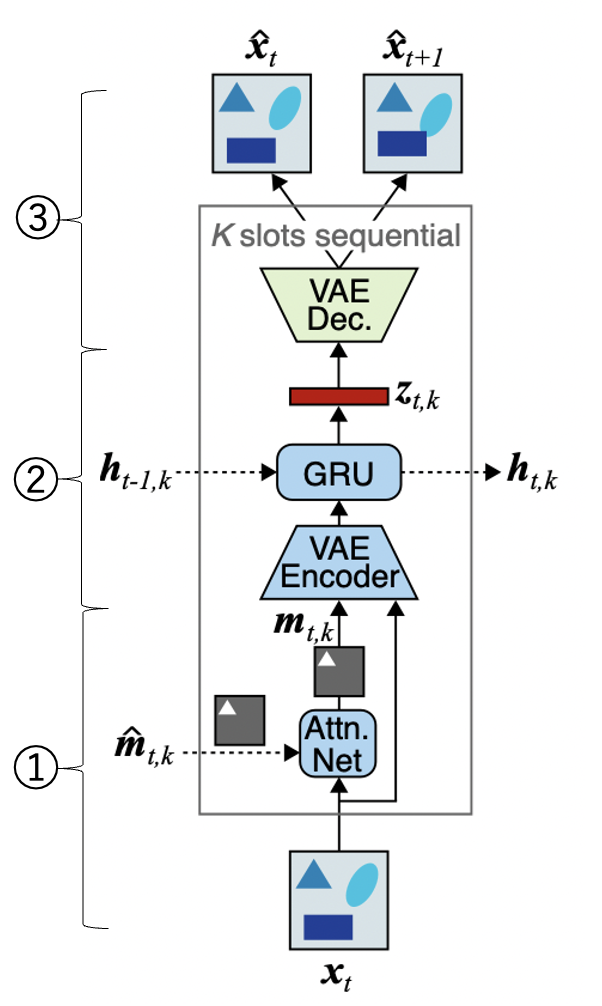

### 3.1 VAE encoder

まず，VAE部分の実装をしていきます．エンコーダはシンプルなconvolutionエンコーダになります．

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, config) -> None:
        """
        VAEエンコーダ

        Parameters
        ----------
        config['vae']['latent_dim'] : int
            VAE潜在空間の次元数
        """
        super().__init__()
        self.latent_dim = config['vae']['latent_dim']

        self.g = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), # 少しメモリを節約できるオプション
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2 * self.latent_dim)
        )

    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor ( b, c + 1, h, w )
            現在フレーム画像x_tと，attention networkから計算したマスクをconcatしたもの

        Returns
        ----------
        mu_logvar : torch.Tensor ( b, latent_dim * 2 )
            潜在変数のガウス分布の平均と（対数）分散
        """
        mu_logvar = self.g(x)
        return mu_logvar

### 3.2 VAE decoder

デコーダでは，物体中心表現学習でよく使われるSpatial Broadcast decoder [[3]](https://arxiv.org/abs/1901.07017)を利用します．Spatial Broadcast decoderは，表現から位置的な特徴を分離する帰納バイアスの役割を果たしています（画像は[[3]](https://arxiv.org/abs/1901.07017)より抜粋）．

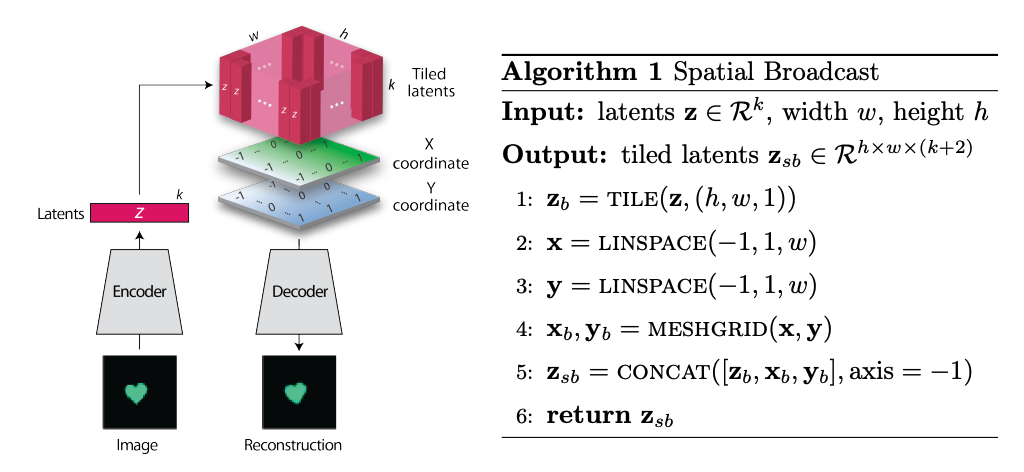

In [ ]:
class BroadcastConvDecoder(nn.Module):
    def __init__(self, config):
        """
        Spatial broadcastありVAEデコーダ．格子状にブロードキャストしてから
        convolutionネットワークに通す．

        Parameters
        ----------
        config['data]['im_size'] : int
            入力フレームサイズ
        config['vae']['latent_dim'] : int
            VAE潜在空間の次元数
        """
        super().__init__()
        self.im_size = config['data']['im_size'] + 8
        self.latent_dim = config['vae']['latent_dim']
        self._init_grid()

        self.h = nn.Sequential(
            nn.Conv2d(self.latent_dim + 2, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),
            nn.Conv2d(32, 4, kernel_size=1, stride=1, padding=0)
        )

    def _init_grid(self) -> None:
        """
        [-1, 1]^2に格子を作成，格子点のx,y座標を取得
        """
        x = torch.linspace(-1, 1, self.im_size)
        y = torch.linspace(-1, 1, self.im_size)
        self.x_grid, self.y_grid = torch.meshgrid(x, y) # ともに ( im_size, im_size )
        # https://pytorch.org/docs/stable/generated/torch.meshgrid.html

    def broadcast(self, z) -> torch.Tensor:
        """
        Broadcastしてからデコーダネットワークに通す．

        Parameters
        ----------
        z : torch.Tensor ( b, latent_dim )
            VAEの潜在変数

        Returns
        ----------
        z_b : torch.Tensor ( b, latent_dim + 2, im_size, im_size )
        """
        b = z.shape[0]

        x_grid = self.x_grid.expand(b, 1, -1, -1).to(z.device) # ( b, 1, im_size, im_size )
        y_grid = self.y_grid.expand(b, 1, -1, -1).to(z.device) # ( b, 1, im_size, im_size )

        # 空間方向に潜在変数をブロードキャスト
        z_a = z.view((b, -1, 1, 1)) # ( b, latent_dim, 1, 1 )
        z_a = z_a.expand(-1, -1, self.im_size, self.im_size) # ( b, latent_dim, im_size, im_size )

        z_b = torch.cat((z_a, x_grid, y_grid), dim=1) # ( b, latent_dim + 2, im_size, im_size )
        return z_b

    def forward(self, z):
        """
        順伝播．zを受け取りxとmを出力する．図は\hat{x}_tと\hat{x}_t+1を出力する
        ような書き方をしているので注意

        Parameters
        ----------
        z : torch.Tensor ( b, latent_dim )
            VAEの潜在変数

        Returns
        ----------
        x_k_mu : torch.Tensor ( b, c, h, w )
            tでは画像の再構成，t+1では次フレームの予測
        m_k_logits : torch.Tensor ( b, 1, h, w )
            マスク予測
        """
        z_b = self.broadcast(z) # ( b, latent_dim + 2, im_size, im_size )

        x = self.h(z_b) # ( b, c + 1, h, w )

        x_k_mu = x[:, :3] # ( b, c, h, w )
        m_k_logits = x[:, 3:] # ( b, 1, h, w )

        return x_k_mu, m_k_logits

### 3.3 Attention network

次にAttention network部分の実装です．Attention networkはU-netで実装します．

U-net [[4]](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)は，セマンティックセグメンテーション領域で提案されたモデルです．エンコーダの情報がデコーダに伝わるように，エンコーダの特徴マップをデコーダの特徴マップに連結させています．

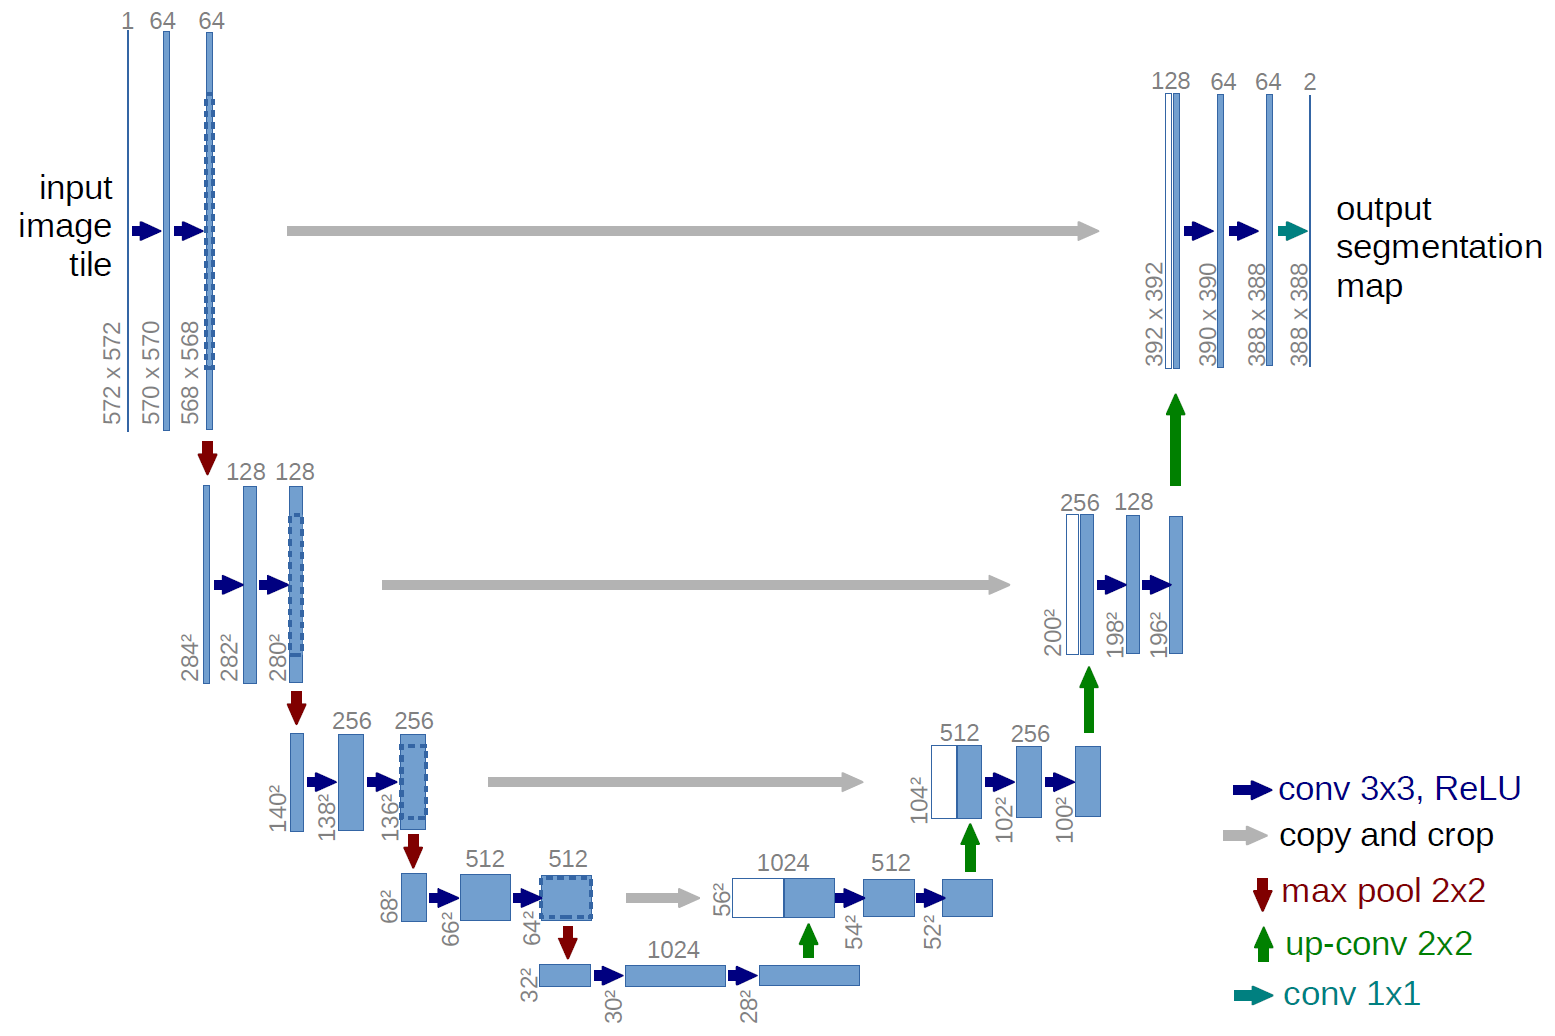

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_ch, out_ch, resize=True, factor=2., skip=True):
        """
        U-Net各層にあるConvブロック

        Parameters
        ----------
        in_ch : int
            畳み込みの入力チャンネル数
        out_ch : int
            畳み込みの出力チャンネル数
        resize : bool
            Up-/ down-samplingを行うかどうか
        factor : float
            Up-/ down-samplingするときの倍率
        skip : bool
            順伝播でskip connection用のTensorを返すかどうか
        """
        super().__init__()

        self._resize = resize
        self._factor = factor
        self._skip = skip

        self.conv = nn.Conv2d(
            in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.inst_norm = nn.InstanceNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor ( b, c', h', w' )

        Returns
        ----------
        out : torch.Tensor ( b, c'', h'', w'' )
        skip : torch.Tensor ( b, c'', h', w' )
            Skip connection用のデコーダブロックに直接渡すTensor
        """
        x = self.conv(x)
        x = self.inst_norm(x)
        out = skip = self.relu(x)

        if self._resize:
            out = F.interpolate(out, scale_factor=self._factor, mode='nearest')

        if self._skip:
            return out, skip
        else:
            return out


class Encoder(nn.Module):
    def __init__(self, block, in_ch, out_ch):
        """
        Attention network (U-Net)のエンコーダ部分

        Parameters
        ----------
        block : AttentionBlock
        in_ch : List[int]
            各ブロックの入力チャンネル数
        out_ch : List[int]
            各ブロックの出力チャンネル数
        """
        super().__init__()
        assert len(out_ch) == len(in_ch)

        self.n_blocks = len(out_ch)
        self.blocks = nn.ModuleList()

        for i in range(self.n_blocks):
            resize = False if i == self.n_blocks -1 else True
            self.blocks.append(block(in_ch[i], out_ch[i], resize=resize, factor=.5))

    def forward(self, x):
        """
        n_blocks個のブロックに入力を通してdownsampling

        Parameters
        ----------
        x : torch.Tensor ( b, c + 2, im_size, im_size )
            入力画像x_t, 前ステップの予測マスク\hat{m}_{t,k}，スコープs_{t,k-1}を
            concatしたもの

        Returns
        ----------
        x : torch.Tensor ( b, c', h', w' )
        skips : List[torch.Tensor]
            Skip connection用のデコーダブロックに直接渡すTensor
        """
        skips = []
        for i in range(self.n_blocks):
            x, skip = self.blocks[i](x)
            skips.append(skip)

        return x, skips


class Decoder(nn.Module):
    def __init__(self, block, in_ch, out_ch):
        """
        Attention network (U-Net)のデコーダ部分

        Parameters
        ----------
        block : AttentionBlock
        in_ch : List[int]
            各ブロックの入力チャンネル数
        out_ch : List[int]
            各ブロックの出力チャンネル数
        """
        super().__init__()
        assert len(out_ch) == len(in_ch)

        self.n_blocks = len(out_ch)
        self.blocks = nn.ModuleList()
        for i in range(self.n_blocks):
            resize = False if i == self.n_blocks -1 else True
            self.blocks.append(block(in_ch[i], out_ch[i], resize=resize, factor=2., skip=False))

        # マスク画像はVAEへの入力として最終的に1チャンネルになる.
        self.conv = nn.Conv2d(
            out_ch[-1], 1, kernel_size=1, stride=1, padding=0, bias=False
        )

    def forward(self, x, skips):
        """
        n_blocks個のブロックに入力を通してupsampling

        Parameters
        ----------
        x : torch.Tensor ( b, c', h', w' )
            エンコーダとボトルネック部のMLPを通ってきた表現
        skips : List[torch.Tensor]
            Skip connection

        Returns
        ----------
        x : torch.Tensor ( b, 1, im_size, im_size )
            現在ステップのマスクm_{t,k}
        """
        for i in range(self.n_blocks):
            # skipsからLIFOで取っていく
            x = torch.cat([x, skips[-(i+1)]], dim=1)
            x = self.blocks[i](x)

        x = self.conv(x)

        return x


class AttentionModule(nn.Module):
    def __init__(self, encoder, decoder, in_ch=5, mlp_ch=256, n_sp=4):
        """
        エンコーダとデコーダからU-Netを構成する．

        Parameters
        ----------
        encoder : Encoder
        decoder : Decoder
        in_ch : int
            入力チャンネル数．入力画像（3チャンネル），前ステップの予測マスク（1チャンネル），
            スコープ（1チャンネル）がconcatされるので5
        mlp_ch : int
            ボトルネック部のMLPを通った後のチャンネル数
        n_sp : int
            デコーダ入力のサイズ
        """
        super().__init__()

        self.in_ch = in_ch
        self.mlp_ch = mlp_ch
        self.n_sp = n_sp
        n_ch = mlp_ch * n_sp * n_sp

        self.encoder = encoder
        self.decoder = decoder

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_ch, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, n_ch),
            nn.ReLU(True),
        )

    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor ( b, in_ch (= c + 2), im_size, im_size )
            入力画像x_t, 前ステップの予測マスク\hat{m}_{t,k}，スコープs_{t,k-1}を
            concatしたもの

        Returns
        ----------
        x : torch.Tensor ( b, 1, im_size, im_size )
            現在ステップのマスクm_{t,k}
        """
        assert x.shape[1] == self.in_ch

        x, skips = self.encoder(x)

        x = self.mlp(x)
        x = x.view(-1, self.mlp_ch, self.n_sp, self.n_sp)

        x = self.decoder(x, skips)
        return x


def create_attn_model(in_ch=5):
    """ U-Netによるattention networkの構築 """
    encoder = Encoder(AttentionBlock, [in_ch, 32, 32, 32, 32], [32, 32, 32, 32, 32])
    decoder = Decoder(AttentionBlock, [64, 64, 64, 64, 64], [32, 32, 32, 32, 32])

    model = AttentionModule(encoder, decoder, in_ch, mlp_ch=32, n_sp=4)
    return model

### 3.4 ViMON

最後に今まで定義したVAE部分とAttention Network部分を組み合わせ，ViMONモデルを作成します．

- $\phi$：　VAEエンコーダのパラメータ
- $\theta$：　VAEデコーダのパラメータ
- $\psi$：　Attention networkのパラメータ

#### 目的関数

ViMONの誤差関数（負のELBO）は，以下の通りです．

$$
L(\phi; \theta; \psi; \mathbf{x}) = \sum_{t=1}^{T} L_{negLL} + βL_{prior} + γL_{mask}
$$

- $L_{negLL}$はデコーダ（混合ガウス分布）の負の対数尤度です．

  - 元のMONetでは$L_{negLL}$の第1項しかありませんが，ViMONでは次ステップの予測および生成を学習するため，予測した次ステップの潜在変数$\hat{z}_{t+1,k}$およびそれから生成した画像$\mathbf{x}_{t+1}$とマスク$\mathbf{m}_{t+1,k}$による第2項があります．

$$
L_{negLL}= - \left[ \log \sum_{k=1}^{K} \mathbf{m}_{t,k} \: p_{\theta}(\mathbf{x}_{t} | \mathbf{z}_{t,k})
+ \log \sum_{k=1}^{K} \mathbf{m}_{t+1,k} \: p_{\theta}(\mathbf{x}_{t+1}|\hat{\mathbf{z}}_{t+1,k}) \right]
$$

- $L_{prior}$は事前分布$p(\mathbf{z})＝N(0,I)$と事後分布$q_{\phi}(\mathbf{z}_{k} | \mathbf{x}, \mathbf{m}_{k})$間のKLダイバージェンスで，VAEの正則化項にあたります．

$$
L_{prior} = D_{KL} \left[ \prod_{k=1}^{K} q_{\phi}(\mathbf{z}_{t,k} | \mathbf{x}_{t}, \mathbf{m}_{t,k})∥p(\mathbf{z}) \right]
$$

- $L_{mask}$は，推論したマスクと潜在変数から生成したマスクのKLダイバージェンスになっており，VAEによるマスク予測 $p_{\theta} (\mathbf{m}_k | \mathbf{z}_k)$がattention mask $q_{\psi} (\mathbf{m}_k | \mathbf{x})$に近くなることを促しています．

  - なお$L_{mask}$の第2項は，$L_{negLL}$と同様，次ステップの予測や生成の学習のために導入されています．

$$
L_{mask} = \sum_{k=1}^{K} D_{KL} \left[ q_{\psi}(\mathbf{m}_{t,k} | \mathbf{x}_{t})∥p_{\theta}(\mathbf{m}_{t,k} | \mathbf{z}_{t,k}) \right]
+ D_{KL} \left[ q_{\psi}(\mathbf{m}_{t+1,k} | \mathbf{x}_{t+1})∥p_{\theta}(\mathbf{m}_{t+1,k}|\hat{\mathbf{z}}_{t+1,k}) \right]
$$

上記のマスク推論モデル $q_{\psi}(\mathbf{m}_{t,k} | \mathbf{x}_{t})$は，Attention Networkによって次のように定義されます．

\begin{aligned}
\mathbf{m}_{t, k} &= s_{t,k-1} \alpha_{\psi} \left( \mathbf{x}_{t}, s_{t,k-1}, \hat{\mathbf{m}}_{t,k} \right) \\
s_{t, k} &= s_{t, k} \left( 1 - \alpha_{\psi} \left( \mathbf{x}_{t}, s_{t, k-1}, \hat{\mathbf{m}}_{t, k} \right) \right)
\end{aligned}

$\alpha_{\psi}$はAttention Network，$s$はスコープを表します．$k=0$のとき$s_{t,0}=\mathbf{1}$，つまりどのピクセルも「説明」されていないことに対応します．$k$が大きくなるにつれて説明される（0になる）ピクセルが増えて，$s_{K-1}$のときに$m_K$と等しくなります．

<img src=" 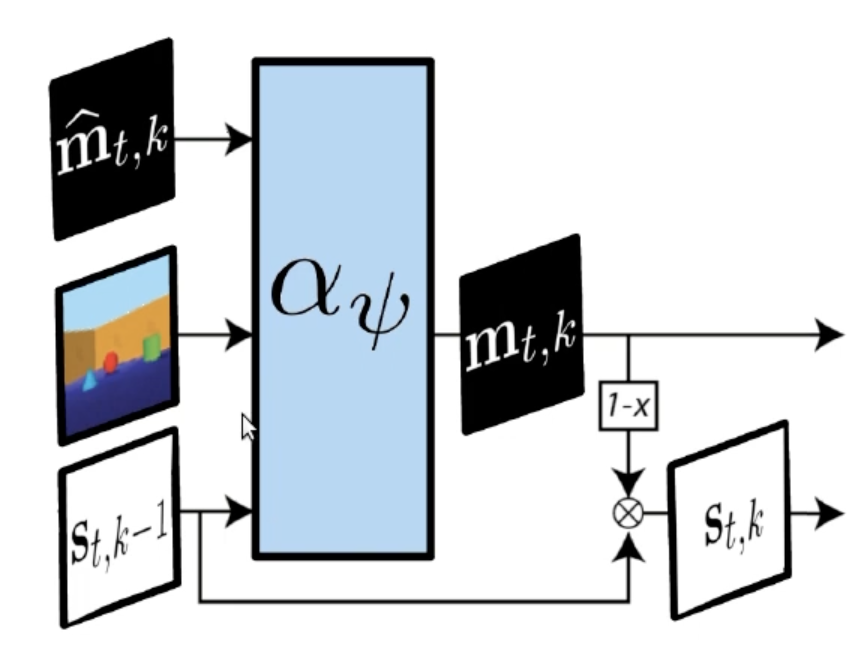" width=400>

In [ ]:
class ViMON(nn.Module):
    def __init__(self, config, attn_module, vae_encoder, vae_decoder, inference=False) -> None:
        """
        Parameters
        ----------
        config['model']['n_slots'] : int
            スロット数（1スロットが1つのオブジェクトに対応）
        config['data']['n_steps'] : int
            使用する動画のフレーム数
        config['vae']['latent_dim'] : int
            VAE潜在空間の次元数
        config['gru']['latent_dim'] : int
            GRU潜在空間の次元数
        attn_module : AttentionModule
        vae_encoder : ConvEncoder
        vae_decoder : BroadcastConvDecoder
        inference : bool
        """
        super().__init__()

        self.inference = inference
        self.attn_module = attn_module

        self.n_slots = config['model']['n_slots']
        self.n_steps = config['data']['n_steps'] if inference else config['data']['n_steps'] - 1
        self.latent_dim = config['vae']['latent_dim']
        self.gru_dim = config['gru']['latent_dim']

        # 混合ガウス分布のそれぞれの標準偏差はあらかじめ決めて固定．最初のスロットは背景と対応づけ，小さくしておく．
        self.sigma = torch.cat(
            [torch.Tensor([0.09]), torch.Tensor([0.11]).repeat(self.n_slots - 1)]
        )[None, :, None, None, None] # ( 1, n_slots, 1, 1, 1 )

        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.criterion_kl = nn.KLDivLoss(reduction='batchmean')

        self.gru = nn.GRU(self.latent_dim * 2, self.gru_dim, batch_first=True)
        self.mlp = nn.Linear(self.gru_dim, 2 * self.latent_dim)
        self.linear = nn.Linear(self.latent_dim, self.latent_dim)  # 次ステップの潜在変数\hat{z}_{t+1,k}の予測用
        self.vae_encoder = vae_encoder
        self.vae_decoder = vae_decoder

        self._init_weights()

    def _init_weights(self) -> None:
        """ GRU，線形層の重みの初期化 """
        self.gru.bias_hh_l0.data.fill_(0)
        self.gru.bias_ih_l0.data.fill_(0)
        self.gru.weight_hh_l0.data.normal_(0, 1e-3)
        rand = torch.randn(3 * self.gru_dim, 2 * self.latent_dim) * 1e-3
        eye = rand + torch.cat(
            [torch.zeros(2 * self.gru_dim, 2 * self.latent_dim), torch.eye(self.gru_dim)[:, :2 * self.latent_dim]]
        )
        self.gru.weight_ih_l0.data.copy_(eye)

        self.mlp.apply(self._init_eye)
        self.linear.apply(self._init_eye)

    def _init_eye(self, m) -> None:
        if type(m) == nn.Linear:
            m.bias.data.fill_(0)
            torch.nn.init.eye_(m.weight)

    def reparameterize(self, mu, logvar):
        """
        VAEの再パラメータ化トリック

        Parameters
        ----------
        mu : torch.Tensor ( b, latent_dim )
            ガウス分布の平均
        logvar : torch.Tensor ( b, latent_dim )
            ガウス分布の分散の対数

        Returns
        ----------
        z_tk : torch.Tensor ( b, latent_dim )
            微分可能な形でガウス分布からサンプリングした値
        """
        if self.inference:
            return mu
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)

            return mu + eps * std

    @staticmethod
    def gauss_prob(preds, targets, sigma):
        """
        ガウス分布の尤度の定義

        Parameters
        ----------
        preds : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, c, h, w )
            x
        targets : torch.Tensor ( b, n_steps or n_steps - 1, 1, c, h, w )
            mu
        sigma : torch.Tensor ( 1, n_slots, 1, 1, 1 )
            標準偏差

        Returns
        ----------
        prob : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, c, h, w )
        """
        return torch.exp(-torch.pow(preds - targets, 2) / (2 * torch.pow(sigma, 2))) / torch.sqrt(2 * sigma**2 * math.pi)

    @staticmethod
    def kl_div(mu, logvar):
        """
        ガウス分布（平均mu，分散var）と単位ガウス分布（平均0，分散I）のKLダイバージェンスの定義
        https://leenashekhar.github.io/2019-01-30-KL-Divergence/ の最後などを参照

        Parameters
        ----------
        mu : torch.Tensor ( b, n_steps, n_slots, latent_dim )
            事後分布の平均
        logvar : torch.Tensor ( b, n_steps, n_slots, latent_dim )
            事後分布の（対数）分散

        Returns
        ----------
        kl_loss : torch.Tensor (, )
        """
        return - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=3).mean(dim=(0, 1)).sum()

    def decoder_loglikelihood(self, target, slot_recon, mask_recon):
        """
        デコーダの尤度（混合ガウス分布）の定義

        Parameters
        ----------
        target : torch.Tensor ( b, n_steps or n_steps - 1, 1, c, h, w )
            入力動画 x_{1:T}の対応する部分
        slot_recon : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, c, h, w )
            VAE Decoderの出力（全スロット）
        mask_recon : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, 1, h, w )

        Returns
        ----------
        recon_loss : torch.Tensor (, )
            x_tの再構成誤差またはx_{t+1}の生成誤差
        """
        b, T, _, _, _, _ = target.size()

        # 混合ガウス分布の混合率
        mask_recon = F.softmax(mask_recon, dim=2)
        # それぞれのガウス分布の尤度（再構成誤差）
        x_prob = self.gauss_prob(slot_recon, target, self.sigma.to(slot_recon.device)) # WRITE ME
        # ( b, n_steps or n_steps - 1, n_slots, c, h, w )

        # 混合ガウス分布の尤度
        masked_x_prob = torch.sum(mask_recon * x_prob, dim=2) # WRITE ME
        # ( b, n_steps or n_steps - 1, c, h, w )
        masked_x_prob = torch.clamp(masked_x_prob, min=1e-5) # 最小値を1e-5にする．

        return - torch.log(masked_x_prob).sum() / (b * T)

    def accumulate_losses(self, target, curr_slots, curr_masks, next_slots, next_masks, attn_masks):
        """
        誤差の計算（目的関数第1,3項）

        Parameters
        ----------
        target : torch.Tensor ( b, T, c, h, w )
            入力動画 x_{1:T}
        curr_slots : torch.Tensor ( b, n_steps(= T - 1), n_slots, c, h, w )
            VAE Decoderの出力 \hat{x}_t
        curr_masks : torch.Tensor ( b, n_steps(= T - 1), n_slots, 1, h, w )
            VAE Decoderの出力 \hat{m}_t
        next_slots : torch.Tensor ( b, n_steps(= T - 1), n_slots, c, h, w )
            VAE Decoderの出力 \hat{x}_{t+1}
        next_masks : torch.Tensor ( b, n_steps(= T - 1), n_slots, 1, h, w )
            VAE Decoderの出力 \hat{m}_{t+1}
        attn_masks : torch.Tensor ( b, n_steps(= T - 1), n_slots, 1, h, w )
            Attention networkの出力 m_{t,k}

        Returns
        ----------
        losses : Dict[str, torch.Tensor]
        """
        b, T, _, _, _ = target.size()

        # -------------------------
        # 負の対数尤度（L_{negLL}）
        # -------------------------
        # x_tの再構成誤差
        recon_loss = self.decoder_loglikelihood(
            target[:, :-1, None, ...], curr_slots, curr_masks
        )# WRITE ME

        # x_{t+1}の生成誤差
        pred_loss = self.decoder_loglikelihood(
            target[:, 2:, None, ...], next_slots[:, 1:], next_masks[:, 1:]
        )

        # -------------------------------------
        # マスクのKLダイバージェンス（L_{mask}）
        # -------------------------------------
        # 推論（m_{t,k}）
        curr_mask_loss = self.criterion_kl(curr_masks.log_softmax(dim=2), attn_masks) / (T - 1)# WRITE ME

        # 次ステップの推論（m_{t+1,k}）
        next_mask_loss = self.criterion_kl(
            next_masks.log_softmax(dim=2)[:, 1:-1], attn_masks[:, 2:]
        ) / (T - 2)

        losses = {
            'recon_loss': recon_loss,
            'pred_loss': pred_loss,
            'curr_mask_loss': curr_mask_loss,
            'next_mask_loss': next_mask_loss
        }
        return losses


    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor ( b, T, c, h, w )

        Returns
        ----------
        results : Dict[str, torch.Tensor]
            再構成された動画，マスクなどの結果
        losses : Dict[str, torch.Tensor]
        """
        b, _, c, h, w = x.size()

        # 空のtensor作成

        # Attention networkの出力マスクを保持
        attn_log_masks = torch.empty((b, self.n_steps, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)

        # ステップtのマスク予測\hat{m}_tを保持
        curr_masks = torch.empty((b, self.n_steps, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)
        # ステップtの再構成画像\hat{x}_tを保持
        curr_slots = torch.empty((b, self.n_steps, self.n_slots, 3, h, w), dtype=torch.float, device=x.device)

        # ステップt+1のマスク予測\hat{m}_{t+1}を保持
        next_masks = torch.empty((b, self.n_steps, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)
        # ステップt+1の画像予測\hat{x}_{t+1}を保持
        next_slots = torch.empty((b, self.n_steps, self.n_slots, 3, h, w), dtype=torch.float, device=x.device)

        # ステップtのVAE潜在変数z'_{t,k}を保持
        mu = torch.empty((b, self.n_steps, self.n_slots, self.latent_dim), dtype=torch.float, device=x.device)
        logvar = torch.empty((b, self.n_steps, self.n_slots, self.latent_dim), dtype=torch.float, device=x.device)

        prev_hidden = torch.zeros((self.n_slots, 1, b, self.gru_dim), dtype=torch.float, device=x.device)
        # ステップt-1のマスク
        prev_masks = torch.zeros((b, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)

        # タイムステップ分
        for t in range(self.n_steps):
            log_s_k = torch.zeros((b, 1, h, w), dtype=torch.float, device=x.device)
            hidden = []
            masks = []

            if t != 0:
                prev_masks = self.logsoftmax(prev_masks)

            # スロット分（対象物体分）ループ
            for k in range(self.n_slots):
                # -----------------------------
                # ①にあたる部分 - マスクの推論
                # -----------------------------
                if k != self.n_slots - 1:
                    # Attention networkへの入力：現在フレーム画像，スコープ，前ステップのマスク予測
                    input_attn = torch.cat([x[:, t], log_s_k, prev_masks[:, k]], dim=1) # ( b, c + 2, h, w )

                    alpha_k = self.attn_module(input_attn) # ( b, 1, h, w )

                    # アテンションマスクの計算
                    log_m_k = log_s_k + F.logsigmoid(alpha_k)
                    # スコープの計算
                    log_s_k = log_s_k + F.logsigmoid(-alpha_k)
                else:
                    # 最後のスロットについてはフレームのこれまでに処理されていない部分とする．
                    log_m_k = log_s_k

                # -----------------------------
                #  ②にあたる部分 - update GRU
                # -----------------------------
                # VAE Encoderにx_tとm_{t,k}をconcatして入力
                input_enc = torch.cat([x[:, t], log_m_k], dim=1)  # ( b, c + 1, h, w )
                z_k = self.vae_encoder(input_enc)  # ( b, latent_dim * 2 )

                # 潜在変数を入力しGRUの状態を更新
                z_ = z_k[:, None, :] / 5.  # ( b, 1, latent_dim * 2 )
                # NOTE: batch_firstはhidden / cell statesには当てはまらない．
                out_gru_k, hidden_k = self.gru(z_, prev_hidden[k].contiguous())  # ( b, 1, gru_dim ), ( 1, b, gru_dim )
                out_gru_k_ = out_gru_k * 5.

                # VAEの潜在変数（z_{t,k}）に再変換
                out_k = self.mlp(out_gru_k_)  # ( b, 1, latent_dim * 2 )

                mu[:, t, k] = out_k[:, 0, :self.latent_dim]  # ( b, latent_dim )
                logvar[:, t, k] = out_k[:, 0, self.latent_dim:]  # ( b, latent_dim )

                z_tk = self.reparameterize(mu[:, t, k], logvar[:, t, k])  # ( b, latent_dim )

                # -----------------------------
                # ③にあたる部分
                # -----------------------------
                # 線形変換で次ステップの\hat{z}_{t+1,k}を予測
                z_tk_pred = self.linear(z_tk)
                # 同じVAE Decoderに通して現在ステップと次ステップの再構成画像とマスクを出力
                curr_slots[:, t, k], curr_masks[:, t, k] = self.vae_decoder(z_tk)  # ( b, c, h, w ), ( b, 1, h, w )
                next_slots[:, t, k], next_masks[:, t, k] = self.vae_decoder(z_tk_pred)  # ( b, c, h, w ), ( b, 1, h, w )

                # 次ステップでattention networkに入れる，VAEのマスク予測\hat{m}_{t,k+1}
                masks.append(next_masks[:, t, k])  # ( b, 1, h, w )
                # Attention networkのマスク出力（ロス計算に使用）
                attn_log_masks[:, t, k] = log_m_k  # ( b, 1, h, w )
                # GRUの隠れ状態
                hidden.append(hidden_k)

            prev_hidden = hidden
            prev_masks = torch.stack(masks, dim=1) # ( b, n_slots, 1, h, w )

        attn_masks = attn_log_masks.exp()
        losses = {}

        # 誤差関数をlosses（dict）に保存
        if not self.inference:
            # 事前分布とのKLダイバージェンス
            kl_loss = self.kl_div(mu, logvar)

            losses = self.accumulate_losses(x, curr_slots, curr_masks, next_slots, next_masks, attn_masks)
            losses.update({'kl_loss': kl_loss})

        # 画像やマスクの生成結果をresults（dict）に保存
        curr_masks = F.softmax(curr_masks, dim=2)
        next_masks = F.softmax(next_masks, dim=2)
        recon_vae = (curr_masks.detach() * curr_slots.detach()).sum(dim=2)
        recon_attn = (attn_masks.detach() * curr_slots.detach()).sum(dim=2)
        pred_vae = (next_masks.detach() * next_slots.detach()).sum(dim=2)

        results = {
            'curr_masks': curr_masks.detach(),
            'next_masks': next_masks.detach(),
            'attn_masks': attn_masks.detach(),
            'recon_vae': recon_vae,
            'recon_attn': recon_attn,
            'pred_vae': pred_vae,
            'curr_slots':  curr_slots.detach(),
            'next_slots':  next_slots.detach(),
        }
        return results, losses

# ViMONを構築
def build_vimon(config, inference=False):
    vae_encoder = ConvEncoder(config)
    vae_decoder = BroadcastConvDecoder(config)
    attn_module = create_attn_model(in_ch=5)
    vimon = ViMON(config, attn_module, vae_encoder, vae_decoder, inference=inference)
    return vimon

## 4.学習

### 4.1 Trainerクラス

In [ ]:
class AverageMeter(object):
    """平均値と現在値を計算し, 保存"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Trainerクラスで学習の設定を行います.
# 学習の設定を変えたい場合は, config.jsonファイルの中身を変更してください.

class Trainer(object):
    def __init__(self, config, model, dataloaders):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.config = config
        self.ckpt_dir = config['trainer']['ckpt_dir']

        # train, valのデータローダー
        self.train_loader = dataloaders[0]
        self.val_loader= dataloaders[1]

        # 学習パラメータ
        self.epochs = config['trainer']['epochs']
        self.start_epoch = 0
        self.best_val_acc = np.inf
        self.best_val_epoch = 0
        self.log_loss_every = config['trainer']['log_loss_every']
        self.beta = config['trainer']['beta']
        self.gamma = config['trainer']['gamma']

        self.criterion_recon = nn.MSELoss(reduction='none')
        self.optimizer = optim.Adam(list(self.model.parameters()), lr=config['optimizer']['lr'])


    def train(self):
        for epoch in range(self.start_epoch, self.epochs):
            # run epoch
            self._train_epoch(epoch)
            acc = self._evaluate(epoch)

            is_best = self.best_val_acc > acc
            self.best_val_acc = np.min([self.best_val_acc, acc])
            if is_best:
                self.best_val_epoch = epoch

            # checkpointでの保存
            self._save_checkpoint(epoch, best=is_best)
        print('Best validation accuracy of {} in epoch {}.'.format(self.best_val_acc, self.best_val_epoch))


    def _train_epoch(self, epoch):
        self.model.train()
        losses = AverageMeter()
        for i, data in enumerate(self.train_loader, 0):
            x = data.float().to(self.device)
            n, t, _, _, _ = x.size()

            self.optimizer.zero_grad()
            results, losses_dict = self.model(x)

            # lossの計算 𝐿(φ;θ;ψ;𝑥) = ∑𝐿𝑛𝑒𝑔𝐿𝐿 + β𝐿𝑝𝑟𝑖𝑜𝑟 + γ𝐿𝑚𝑎𝑠𝑘
            loss = (
                losses_dict['recon_loss']
                + losses_dict['pred_loss']
                + self.beta * losses_dict['kl_loss']
                + self.gamma * (losses_dict['curr_mask_loss'] + losses_dict['next_mask_loss'])
            )

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10.)

            self.optimizer.step()

            losses.update(loss.detach(), n)

            if i % self.log_loss_every == self.log_loss_every - 1:
                print('Epoch {} [{}|{}] | Loss {:.4f}'.format(epoch, i, len(self.train_loader), losses.avg))


    def _evaluate(self, epoch):
        self.model.eval()
        recon = AverageMeter()
        with torch.no_grad():
            for i, data in enumerate(self.val_loader, 0):
                x = data.float().to(self.device)
                n, t, _, _, _ = x.size()
                results, losses_dict = self.model(x)
                loss_mse = self.criterion_recon(results['recon_vae'], x[:,:-1]).sum(dim=[2, 3, 4]).mean()
                recon.update(loss_mse.detach(), n)

        print('Epoch {} | Eval MSE: {:.4f}'.format(epoch, recon.avg))
        return recon.avg.item()


    def _save_checkpoint(self, epoch, best=False):
        filename = 'ckpt_vimon_best.pt' if best else 'ckpt_vimon_last.pt'
        PATH = os.path.join(self.ckpt_dir, filename)
        torch.save(self.model.state_dict(), PATH)
        print('Save model after epoch {} as {}.'.format(epoch, filename))

### 4.2 学習

それでは実際に学習を開始してみましょう．

In [ ]:
torch.cuda.empty_cache()

# build model
model = build_vimon(config)
trainer = Trainer(config, model, [train_loader, val_loader])

print('Start training.')
trainer.train()
print('Done.')

Start training.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 [49|625] | Loss 106453.9688
Epoch 0 [99|625] | Loss 59504.9219
Epoch 0 [149|625] | Loss 40985.7031
Epoch 0 [199|625] | Loss 30697.3770
Epoch 0 [249|625] | Loss 23990.9336
Epoch 0 [299|625] | Loss 19369.0840
Epoch 0 [349|625] | Loss 15989.7686
Epoch 0 [399|625] | Loss 13459.5156
Epoch 0 [449|625] | Loss 11426.8994
Epoch 0 [499|625] | Loss 9724.5918
Epoch 0 [549|625] | Loss 8339.6465
Epoch 0 [599|625] | Loss 7143.6753
Epoch 0 | Eval MSE: 775.1132
Save model after epoch 0 as ckpt_vimon_best.pt.
Epoch 1 [49|625] | Loss -6488.2178
Epoch 1 [99|625] | Loss -6823.4429
Epoch 1 [149|625] | Loss -7004.8804
Epoch 1 [199|625] | Loss -7148.8706
Epoch 1 [249|625] | Loss -7371.3110
Epoch 1 [299|625] | Loss -7505.5078
Epoch 1 [349|625] | Loss -7541.6294
Epoch 1 [399|625] | Loss -7645.9424
Epoch 1 [449|625] | Loss -7734.9258
Epoch 1 [499|625] | Loss -7856.6709
Epoch 1 [549|625] | Loss -7949.7090
Epoch 1 [599|625] | Loss -8030.7300
Epoch 1 | Eval MSE: 741.1438
Save model after epoch 1 as ckpt_vim

演習中に全epochでの学習を実行することはできないので，以降の「6. 結果の確認」では，予め学習した後の重み(`ckpt_vimon_vmds.pt`)を使用し，結果を確認していきます．

## 5.結果の確認

学習したモデルを用いて，テストデータでの結果を確認します．

テストデータの任意のシーンにおける物体分割の予測結果を，元動画と並べて表示します．

まずはテストデータと学習後のモデルの重みを用いて，マスクと画像を生成します．

In [ ]:
# マスクと画像の生成に必要な関数を定義

def binarize_masks(masks):
    '''
    マスクの２値化

    Parameters
    ----------
    masks : torch.Tensor ( n_slots, 1, h, w )

    Returns
    ----------
    binarized_masks : torch.Tensor ( n_slots, 1, h, w )
    '''
    n = masks.size(0)
    idc = torch.argmax(masks, dim=0)
    binarized_masks = torch.zeros_like(masks)
    for i in range(n):
        binarized_masks[i] = (idc == i).int()

    return binarized_masks


def generation_imgs(model, data, n_steps=10, n_slots=6, device=None):
    """
    各スロットの画像生成
    """
    bs = data.size(0)
    # 全スロットのマスクと画像の生成
    with torch.no_grad():
        results, _ = model(data.float().to(device))
    soft_masks = results["curr_masks"].cpu()
    slot_generated_imgs = results["curr_slots"].cpu()

    # 各スロットの生成画像に2値マスクをかける
    for b in range(bs):
        masks_step = []
        for t in range(n_steps):
            binarized_masks = binarize_masks(soft_masks[b,t])
            slot_generated_imgs[b,t] = slot_generated_imgs[b,t] * binarized_masks # マスクがかかっていないところは0にする．

    return slot_generated_imgs

In [ ]:
## モデルとデータセットの読み込み
test_loader = build_testloader(
    batch_size=config['data']['batch_size'],
    num_workers=config['data']['num_workers'],
    n_steps=config['data']['n_steps']
)

# build model
model = build_vimon(config, inference=True)

# 元実装で公開されている学習済みの重み
ckpt = torch.load(
    os.path.join(UTILS_DIR, "lecture08_utils/ckpt_vimon_vmds.pt"),
    map_location=lambda storage, loc: storage
)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [ ]:
# テストデータが与えられた下でのスロットごとの画像生成
test_imgs = next(iter(test_loader))

slot_generated_imgs = generation_imgs(
    model,
    test_imgs,
    n_steps=config['data']['n_steps'],
    n_slots=config['model']['n_slots'],
)

予測結果を表示します．

In [ ]:
def display_video_slots(test_imgs, slot_generated_imgs, plot_id):
    """ 元データと並べて表示するための関数 """
    _, axes = plt.subplots(1, config["model"]["n_slots"] + 1, figsize=(12, 5))
    patches = []
    patches.append(axes[0].imshow(np.transpose(test_imgs[plot_id][0],(1,2,0))))
    axes[0].axis('off')
    for k in range(config["model"]["n_slots"]):
        patches.append(axes[k+1].imshow(np.transpose(slot_generated_imgs[plot_id][0][k],(1,2,0))))
        axes[k+1].axis('off')

    def animate(i):
        patches[0].set_data(np.transpose(test_imgs[plot_id][i],(1,2,0)))
        axes[0].set_title("Original Step %d" % (i))

        for k in range(config["model"]["n_slots"]):
          patches[k+1].set_data(np.transpose(slot_generated_imgs[plot_id][i][k],(1,2,0)))
          axes[k+1].set_title("Slot %d Step %d" % (k, i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=config["data"]["n_steps"], interval=50)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()

In [ ]:
# 表示
display_video_slots(test_imgs, slot_generated_imgs, 0)

適切に学習できていれば，物体ごとの分割が確認できると思います．

以上で演習は終了です．お疲れ様でした．

##6.参考文献

[[1]](https://jmlr.org/papers/volume22/21-0199/21-0199.pdf) Marissa A. Weis, et al., "Benchmarking Unsupervised Object Representations for Video Sequences", Journal of Machine Learning Research 22 (2021) p1-61

[[2]](https://arxiv.org/abs/1901.11390)  Burgess, Christopher P., et al. "Monet: Unsupervised scene decomposition and representation." arXiv preprint arXiv:1901.11390 (2019).

[[3]](https://arxiv.org/abs/1901.07017) Watters, Nicholas, et al. "Spatial broadcast decoder: A simple architecture for learning disentangled representations in vaes." arXiv preprint arXiv:1901.07017 (2019).

[[4]](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.
